# Xi0Stat Tutorial

## Setup

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.cosmology import FlatLambdaCDM

In [3]:
%cd ../

/Users/af/Work/Cosmo/codes/Xi0Stat


In [4]:
from Xi0Stat.globals import * 
from Xi0Stat.GW import get_all_events
from Xi0Stat.GLADE import GLADE
from Xi0Stat.GWENS import GWENS
from Xi0Stat.SYNTH import SYNTH
from Xi0Stat.completeness import *
from Xi0Stat.galCat import GalCompleted
from Xi0Stat.GWgal import GWgal
from Xi0Stat.betaHom import BetaHom

In [5]:
%load_ext autoreload
%autoreload 2

## GW

This module is based on the object Skymap3D. This contains the GW skymap for a single GW event denoted by its name - a string accessible by the attribute self.event_name. E.g.: 'GW170817'
Main attributes:
- npix: N of pixels
- nside : skymap nside
- pixarea: area of a pixel in rad^2
- p: probability in a pixel (the rho of Singer et al.)
- mu, sigma, norm: mu, sigma, N of the skymap 
- metadata: the metadata of the event. The metadata file should be a .csv file in the folder data/GW/metadata (editable in globals/metaPath). For O2, it should be called GWTC-1-confident.csv . The file in csv is downloadable at https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/

Key methods to compute likelihood:

- likelihood(self, r, theta, phi) : likelihood given GW lum distance r, and polar angles theta, phi in radians 
- likelihood_px(self, r, pix) : lileihood  given GW lum distance r and pixel

(Note that the likelihood is a Gaussian truncated at zero. )

- likelihood_in_credible_region(self, r, level=0.99,) : likelihood in all the pixels of the credible region specified by level at given GW lum disance r
- d_max(self, SNR_ref=8): Max GW luminosity distance at which the evend could be seen, assuming its SNR and a threshold SNR_ref:d_max = d_obs*SNR/SNR_ref
- get_zlims(self, H0max=220, H0min=20, Xi0max=3, Xi0min=0.2) : Computes the possible range in redshift for the event given the prior range for H0 and XI0



Other: the module contains the function get_all_events(loc='data/GW/O2/', subset, subset_names) , that reads all the skymaps in the folder specified by loc and returns a dictionary {event name: Skymap3D}

If subset=True, the dictionary will contain only the events specified in subset_names, which should be a list of names, e.g. : get_all_events(loc='data/GW/O2/', subset=True, subset_names=['GW170817',]) to return skymap of GW170817

In [6]:
# Example: load skymaps of O2 events GW170817 

O2 = get_all_events(loc='data/GW/O2/', subset=True, subset_names=['GW170817',])

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


In [7]:
# Example: chech area of the 90% credible region of GW170817

O2['GW170817'].area_p(pp=0.9)

16.15640267031496

## Completeness

In [23]:
compl = SkipCompleteness()

## GLADE

In [24]:
glade = GLADE('GLADE', compl, False)

In [25]:
gals = GalCompleted()
gals.add_cat(glade)

## GWgal

This module contains the object GWgal. Its main attributes are :
- gals : a GalCompleted object
- GWevents: a dictionary {event name: Skymap3D} for the GW events

At initialization, two other attributes will be created:
- cred_pixels : a dictionary {event name: list of pixels of the credible region specified by credible_level (default 0.99)}
- z_lims : a dictionary {event name: (z_min, z_max) } where z_min, z_max are the min and max redshift for all prior ranges in H0 and Xi0 . This is computed using mean+-3sigma with mean and sigma the mu and std of the GW luminosity distance, taken from the header of the skymap 

In [26]:
myGWgal = GWgal(gals, O2)

In [27]:
# Example: z limits for GW170817 with prior range H0max=220, H0min=20, Xi0max=3, Xi0min=0.2

myGWgal.z_lims

{'GW170817': (0.0010314992453354975, 0.04593987289261164)}

## Computing posterior

In [30]:
# Set area and z range in the galaxy catalogue

myGWgal.gals.select_area(myGWgal.cred_pixels['GW170817'], myGWgal.GWevents['GW170817'].nside)


myGWgal.gals.set_z_range_for_selection( *myGWgal.z_lims['GW170817'])


Restricting area of the catalogue to 4928 pixels with nside=1024
1020 galaxies kept
Setting z range of the catalogue between 0.0010314992453354975, 0.04593987289261164
199 galaxies kept


In [47]:
# Compute likelihood for H0 on a grid
H0grid = np.linspace(20, 220, 30)
lik = np.ones(H0grid.shape) 

for i, H0 in enumerate(H0grid): 
    liks = myGWgal.get_inhom_lik(H0, Xi0=1, n=1.91)
    print(liks)
    for key, val in liks.items():
        print(key, val)
        lik[i] *= val 

<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00013707 0.00013706 0.00013705]
 [0.         0.00039535 0.0009505  ... 0.01089152 0.01084105 0.01067538]
 [0.00014216 0.00038339 0.00048242 ... 0.00047963 0.00047957 0.00047954]]
{'GW170817': 4.8156044649555844e-11}
GW170817 4.8156044649555844e-11
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.83960130e-04
  1.83928673e-04 1.83912952e-04]
 [3.15

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


{'GW170817': 3.2996465425507833e-10}
GW170817 3.2996465425507833e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00050692 0.00050668 0.00050657]
 [0.0013716  0.00345734 0.00417048 ... 0.00572758 0.0053103  0.00513221]
 [0.00080754 0.00171373 0.00181194 ... 0.0078839  0.00788582 0.00802235]]
{'GW170817': 4.3200660227928997e-10}
GW170817 4.3200660227928997e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00055233 0.00055205 0.00055191]
 [0.00156299 0.00383994 0.00455269 ... 0.

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


{'GW170817': 5.285531171055571e-10}
GW170817 5.285531171055571e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00187764 0.0021298  0.00212922]
 [0.00175438 0.0042225  0.00493482 ... 0.00517822 0.00517543 0.00488162]
 [0.00097384 0.00204617 0.00214402 ... 0.01004803 0.0101118  0.01018437]]
{'GW170817': 6.014877958164365e-10}
GW170817 6.014877958164365e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00229164 0.00229032 0.00228966]
 [0.00194576 0.00460503 0.00531689 ... 0.0047

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


{'GW170817': 6.493744676721215e-10}
GW170817 6.493744676721215e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00245173 0.00245022 0.00244947]
 [0.00213713 0.00498752 0.00569889 ... 0.00494214 0.00454385 0.00426629]
 [0.00114014 0.00237854 0.00247599 ... 0.01206069 0.01209944 0.01212565]]
{'GW170817': 6.804828156448274e-10}
GW170817 6.804828156448274e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00298029 0.00357265 0.00379679]
 [0.00232849 0.00536998 0.00608083 ... 0.0045

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


{'GW170817': 7.408829189306204e-10}
GW170817 7.408829189306204e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00021424 ... 0.00626918 0.00683584 0.00713495]
 [0.00309384 0.00689947 0.00760788 ... 0.00394394 0.00394079 0.00393921]
 [0.0015558  0.00320923 0.00330538 ... 0.01537012 0.01515973 0.01493487]]
{'GW170817': 7.541588607248569e-10}
GW170817 7.541588607248569e-10
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00028538 ... 0.00748835 0.00765676 0.00819594]
 [0.00328516 0.00728176 0.00798947 ... 0.0041

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


{'GW170817': 1.0139208171189296e-09}
GW170817 1.0139208171189296e-09
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00016918 0.00085413 ... 0.01832212 0.01877123 0.01916017]
 [0.0048154  0.01033884 0.02047272 ... 0.0038554  0.00354059 0.00325282]
 [0.00230376 0.00470352 0.00479643 ... 0.01323442 0.01257259 0.01195208]]
{'GW170817': 1.0577643665219902e-09}
GW170817 1.0577643665219902e-09
<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00021661 0.00092518 ... 0.0196843  0.02015822 0.02051286]
 [0.00500664 0.01072082 0.02360264 ... 0.

/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/af/miniconda3/envs/cobenv/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<class 'int'>
1
<class 'numpy.ndarray'>
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00031146 0.00106725 ... 0.02224383 0.02252327 0.02274679]
 [0.00538909 0.01148468 0.03020569 ... 0.00357716 0.00357284 0.00357069]
 [0.00255301 0.00520135 0.00529292 ... 0.01117095 0.01034793 0.00988087]]
{'GW170817': 1.1996593122603178e-09}
GW170817 1.1996593122603178e-09


<class 'numpy.ndarray'> (30,)
<class 'numpy.ndarray'> (30,)


TypeError: float() argument must be a string or a number, not 'dict'

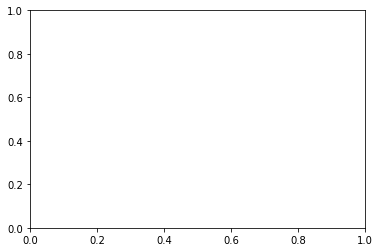

In [41]:
# Plot the posterior with beta=H0^3


norm=np.trapz(lik/H0grid**3, H0grid)

plt.plot(H0grid, lik)#/H0grid**3/norm)